## SeeFood 

For our final project, we wrote a Convolutional Neural Network (CNN) that recognizes whether a 
food image is or is not a hot dog. Our dataset is from [Kaggle](https://www.kaggle.com/datasets/dansbecker/hot-dog-not-hot-dog?datasetId=8552&sortBy=relevance&searchQuery=CNN),
which is compiled from a dataset of 101 different food items. It is separated into test and train 
folders from the get-go, each with 250 pictures of hot dogs and 250 pictures of other food items. So there is a total of 1000 pictures.

In [20]:
import pandas as pd
import tensorflow
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
import numpy as np
import os
import cv2
from bokeh.plotting import figure, output_notebook, show
from sklearn.metrics import confusion_matrix
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import glob
from PIL import Image
output_notebook()

Loading BokehJS ...

These are constants we use throughout the project, including number of epochs and image dimensions.

In [21]:
img_width, img_height = 50, 50
input_shape = (img_width, img_height, 1)
batch_size = 25
num_epochs = 25
num_classes = 2
validation_split = 0.2

#### Image Preprocessing

Here we load the images from the dataset. Based on the `data_type` and `class_type` arguments, we can load test and train data, split into the `hot_dog` and `not_hot_dog` classes.

Because the images of are of various sizes and in color, we have to do some preprocessing to the pictures. We first load
it in grayscale, so that it easier for the neural network to process. Then, we resize the image to
50 x 50 px.

In [22]:
def load_data(data_type, class_type):
    images = []
    labels = []

    for file in os.listdir(f'data/{data_type}/{class_type}'):
        image = cv2.resize(cv2.imread(f'data/{data_type}/{class_type}/{format(file)}', 0), (img_width, img_height))
        images.append(image)
        labels.append(1 if class_type == 'not_hot_dog' else 0)

    return (images, labels)

In [23]:
# load and merge training data
X_train_nh, y_train_nh = load_data(data_type="train", class_type="not_hot_dog")
X_train_h, y_train_h = load_data(data_type="train", class_type="hot_dog")
X_train = np.array(X_train_nh + X_train_h)

# rotation_layer = RandomRotation(0.5)
# rotation_layer = RandomZoom()
# X_train_aug = rotation_layer(X_train).numpy()

# X_train = np.array(X_train + X_train_aug)

X_train = X_train.reshape((X_train.shape[0], img_width, img_height, 1))
y_train = np.array(y_train_nh + y_train_h)

# load and merge testing data
X_test_nh, y_test_nh = load_data(data_type="test", class_type="not_hot_dog")
X_test_h, y_test_h = load_data(data_type="test", class_type="hot_dog")
X_test = np.array(X_test_nh + X_test_h)
X_test = X_test.reshape((X_test.shape[0], img_width, img_height, 1))
y_test = np.array(y_test_nh + y_test_h)

A picture of french fries and a hot dog after the preprocessing.

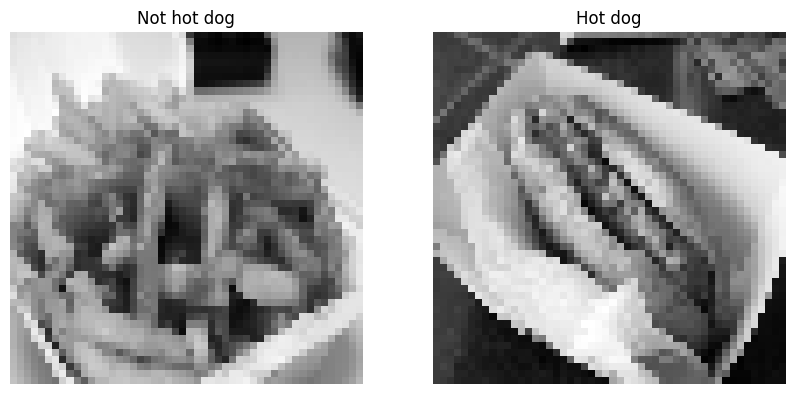

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(X_train_nh[0], cmap="gray")
axes[0].set_title("Not hot dog")
axes[0].axis("off")

axes[1].imshow(X_train_h[0], cmap="gray")
axes[1].set_title("Hot dog")
axes[1].axis("off")

plt.show()

#### Neural Network

Our neural network is a CNN with multiple layers. The first three layers are convolutional layers: (1) input layer with 25 filters, (2) secondary layer with 50 filters, (3) third layer with 100 filters. These convolutional layers are used to extract features from the input images, with each layer learning increasingly complex patterns. The next layer flattens the multidimensional output into a one dimensional layer. This is needed for the dense layers, which are fully connected with 256 neurons and give us our output.

In [25]:
model = Sequential()
model.add(Conv2D(25, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(Conv2D(50, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(100, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [26]:
model.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [27]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    validation_split=validation_split)

Epoch 1/25
16/16 [==============================] - 2s 69ms/step - loss: 509.0888 - accuracy: 0.5201 - val_loss: 1.1900 - val_accuracy: 0.0900
Epoch 2/25
16/16 [==============================] - 1s 58ms/step - loss: 0.5335 - accuracy: 0.7462 - val_loss: 0.7739 - val_accuracy: 0.5300
Epoch 3/25
16/16 [==============================] - 1s 60ms/step - loss: 0.2871 - accuracy: 0.9045 - val_loss: 1.2961 - val_accuracy: 0.4700
Epoch 4/25
16/16 [==============================] - 1s 54ms/step - loss: 0.1430 - accuracy: 0.9447 - val_loss: 0.9536 - val_accuracy: 0.6000
Epoch 5/25
16/16 [==============================] - 1s 53ms/step - loss: 0.0533 - accuracy: 0.9975 - val_loss: 3.1481 - val_accuracy: 0.2900
Epoch 6/25
16/16 [==============================] - 1s 54ms/step - loss: 0.0417 - accuracy: 0.9899 - val_loss: 3.8277 - val_accuracy: 0.1200
Epoch 7/25
16/16 [==============================] - 1s 53ms/step - loss: 0.0176 - accuracy: 0.9975 - val_loss: 2.8116 - val_accuracy: 0.3800
Epoch 8/25


After running the model for 25 epochs, we have a pretty mediocre accuracy of around 50%.

In [28]:
score = model.evaluate(X_test, y_test)

16/16 [==============================] - 1s 26ms/step - loss: 3.2336 - accuracy: 0.5440


To evaluate our model, we show the confusion matrix and some metrics. Our confusion matrix leans
toward positives (hot dog) than negatives.

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)
cm

16/16 [==============================] - 0s 24ms/step


array([[ 74, 176],
       [ 52, 198]])

In [30]:
tn, fp, fn, tp = cm.ravel()
pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1"],
    "Value": [(tp+tn)/(tp+fp+fn+tn), tp/(tp+fp), tp/(tp+fn), (2*tp/(tp+fp))*(tp/(tp+fn)) / ((tp/(tp+fp))+(tp/(tp+fn)))]
})

,Metric,Value
0,Accuracy,0.544000
1,Precision,0.529412
2,Recall,0.792000
3,F1,0.634615


Here is a plot showing the training and validation loss along with their accuracy. As you can see, the validation loss and accuracy are not very good for this model. They don't converge with the rest of the training data. We believe this is because the network overfits to the training data.

In [12]:
# extract loss values from the training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))

# create plot
p = figure(title="Training and Validation Loss", x_axis_label="Epoch", y_axis_label="Loss")
p.line(epochs, train_loss, legend_label="Train Loss", line_color="blue")
p.line(epochs, valid_loss, legend_label="Validation Loss", line_color="red")

# show it
show(p)

train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
epochs = list(range(1, len(train_accuracy) + 1))

p = figure(title="Training and Validation Accuracy", x_axis_label="Epoch", y_axis_label="Accuracy")
p.line(epochs, train_accuracy, legend_label="Train Accuracy", line_color="blue")
p.line(epochs, valid_accuracy, legend_label="Validation Accuracy", line_color="red")

show(p)

##### Image Augmentation

Since our model only ended up giving a result barely higher than chance, we wanted to see if we could improve our results. Since we were working with a dataset on only a few hundred pictures we tried to increase the size of our dataset to try and improve our model's accuracy. We started by loading each datatype and class into lists of jpegs.

In [13]:
images_path1 = glob.glob("data/test/hot_dog/*.jpg")
images_path2 = glob.glob("data/test/not_hot_dog/*.jpg")
images_path3 = glob.glob("data/train/hot_dog/*.jpg")
images_path4 = glob.glob("data/train/not_hot_dog/*.jpg")

images_test_hd = []
images_test_nhd = []
images_train_hd = []
images_train_nhd = []
for img_path in images_path1:
    img = cv2.imread(img_path,0)
    images_test_hd.append(img)
for img_path in images_path2:
    img = cv2.imread(img_path,0)
    images_test_nhd.append(img)
for img_path in images_path3:
    img = cv2.imread(img_path,0)
    images_train_hd.append(img)
for img_path in images_path4:
    img = cv2.imread(img_path,0)
    images_train_nhd.append(img)


To increase the size of our dataset, we augmented our existing photos and added them to the list of the our pictures. There were five operations we performed on each food picture: a horizontal flip, a vertical flip, a flip both ways, a random magnitude of blurring, and a random change of light exposure.

In [14]:
mirror = iaa.Sequential([
    iaa.Fliplr(1),
    ])
flip = iaa.Sequential([
    iaa.Flipud(1),
    ])
mf = iaa.Sequential([
    iaa.Fliplr(1),
    iaa.Flipud(1),
    ])
blur = iaa.Sequential([
    iaa.AverageBlur(2,7)
    ])
contrast = iaa.Sequential([
    iaa.LinearContrast((.7,1.3))
    ])


For each existing photo, we added three differently-blurred instances and one instance of each other augmentation to the data pool.

In [15]:
m_images_test_hd = mirror(images = images_test_hd)
f_images_test_hd = flip(images = images_test_hd)
mf_images_test_hd = mf(images = images_test_hd)
b_images_test_hd = blur(images = images_test_hd) + blur(images = images_test_hd)+ blur(images = images_test_hd)
c_images_test_hd = contrast(images = images_test_hd)

m_images_test_nhd = mirror(images = images_test_nhd)
f_images_test_nhd = flip(images = images_test_nhd)
mf_images_test_nhd = mf(images = images_test_nhd)
b_images_test_nhd = blur(images = images_test_nhd) + blur(images = images_test_nhd) + blur(images = images_test_nhd)
c_images_test_nhd = contrast(images = images_test_nhd)

m_images_train_hd = mirror(images = images_train_hd)
f_images_train_hd = flip(images = images_train_hd)
mf_images_train_hd = mf(images = images_train_hd)
b_images_train_hd = blur(images = images_train_hd) + blur(images = images_train_hd)+ blur(images = images_train_hd)
c_images_train_hd = contrast(images = images_train_hd)


m_images_train_nhd = mirror(images = images_train_nhd)
f_images_train_nhd = flip(images = images_train_nhd)
mf_images_train_nhd = mf(images = images_train_nhd)
b_images_train_nhd = blur(images = images_train_nhd) + blur( images = images_train_nhd)+ blur( images = images_train_nhd)
c_images_train_nhd = contrast(images = images_train_nhd)

In [16]:
images_test_hd = images_test_hd + m_images_test_hd + f_images_test_hd + mf_images_test_hd + b_images_test_hd + c_images_test_hd
images_test_nhd = images_test_nhd + m_images_test_nhd + f_images_test_nhd + mf_images_test_nhd + b_images_test_nhd + c_images_test_nhd
images_train_hd = images_train_hd + m_images_train_hd + f_images_train_hd + mf_images_train_hd + b_images_train_hd + c_images_train_hd
images_train_nhd = images_train_nhd + m_images_train_nhd + f_images_train_nhd + mf_images_train_nhd + b_images_train_nhd + c_images_train_nhd

After saving the new lists to a new directory, we could pull the larger number of pictures back into our model.

In [17]:
image_no = 1
for image in images_test_hd :
    # [...]
    name = 'data/new/test/hot_dog/' + str(image_no) + '.jpg'
    photo = Image.fromarray(image)
    photo.save(name, 'JPEG')
    image_no += 1

image_no = 1

for image in images_test_nhd :
    # [...]
    name = 'data/new/test/not_hot_dog/' + str(image_no) + '.jpg'
    photo = Image.fromarray(image)
    photo.save(name, 'JPEG')
    image_no += 1

image_no = 1

for image in images_train_hd :
    # [...]
    name = 'data/new/train/hot_dog/' + str(image_no) + '.jpg'
    photo = Image.fromarray(image)
    photo.save(name, 'JPEG')
    image_no += 1

image_no = 1

for image in images_train_nhd :
    # [...]
    name = 'data/new/train/not_hot_dog/' + str(image_no) + '.jpg'
    photo = Image.fromarray(image)
    photo.save(name, 'JPEG')
    image_no += 1

In [18]:
img_width, img_height = 100, 100
input_shape = (img_width, img_height, 1)
batch_size = 1400
no_epochs = 25
no_classes = 2
validation_split = 0.1
verbosity = 1

In [19]:
def new_load_data(data_type, class_name):
    instances = []
    classes = []
    for filepath in os.listdir(f'data/new/{data_type}/{class_name}'):
        resized_image = cv2.imread(f'data/new/{data_type}/{class_name}/{format(filepath)}', 0)
        resized_image = cv2.resize(resized_image, (img_width, img_height))
        instances.append(resized_image)
        classes.append(0 if class_name == 'not_hot_dog' else 1)
    return (instances, classes)

In [ ]:

X_train_nh, y_train_nh = new_load_data(data_type='train', class_name='not_hot_dog')
X_train_h, y_train_h = new_load_data(data_type='train', class_name='hot_dog')
X_train = np.array(X_train_nh + X_train_h)
X_train = X_train.reshape((X_train.shape[0], img_width, img_height, 1))
y_train = np.array(y_train_nh + y_train_h)


X_test_nh, y_test_nh = new_load_data(data_type='test', class_name='not_hot_dog')
X_test_h, y_test_h = new_load_data(data_type='test', class_name='hot_dog')
X_test = np.array(X_test_nh + X_test_h)
X_test = X_test.reshape((X_test.shape[0], img_width, img_height, 1))
y_test = np.array(y_test_nh + y_test_h)

In [ ]:
model = Sequential()
model.add(Conv2D(25, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(Conv2D(50, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(100, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            shuffle=True,
            verbose=1,
            validation_split=validation_split)


Epoch 1/25


In [ ]:
score = model.evaluate(X_test, y_test)

Unfortunately, the accuracy of the model was not increased substantially.

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
tn, fp, fn, tp = cm.ravel()
pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1"],
    "Value": [(tp+tn)/(tp+fp+fn+tn), tp/(tp+fp), tp/(tp+fn), (2*tp/(tp+fp))*(tp/(tp+fn)) / ((tp/(tp+fp))+(tp/(tp+fn)))]
})

As shown in the loss plot below, the model still has a gap between training and validation loss.
We may have to investigate other methods to reduce overfitting, such as adding a dropout or max
pool layer to the neural network.

In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))


p = figure(title="Training and Validation Loss", x_axis_label="Epoch", y_axis_label="Loss")
p.line(epochs, train_loss, legend_label="Train Loss", line_color="blue")
p.line(epochs, valid_loss, legend_label="Validation Loss", line_color="red")


show(p)